In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import os
import time
from glob import glob

mpl.rcParams['figure.figsize'] = 12, 8
mpl.rcParams['font.size'] = 18

### In this notebook I'll show use of an adaptive cluster, where Dask will start more nodes when needed for a computation, and close them again once not needed.

I haven't had amazing success using this feature, but it is there, and works well a lot of the time. It seems to have trouble with data that is very large, you could try upping the memory per worker in the call to `SLURMCluster`. It also has trouble if Casper is particularly busy, and there is a wait to start new workers so, your mileage may vary. 

In this example I've specified that the maximum number of jobs for the cluster is 35, since CISL has started enforcing a limit of 36 CPUs for a session on Casper, so, 35 workers and 1 for the CPU running this notebook.

In [2]:
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(project='UWAS0052')
cluster.adapt(maximum_jobs=35)

from dask.distributed import Client
client = Client(cluster)
client

/glade/u/home/apauling/miniconda3/envs/isotope/lib/python3.6/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45186 instead
  http_address["port"], self.http_server.port


Client Scheduler: tcp://10.12.205.30:39008 Dashboard: http://10.12.205.30:45186/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


### I'll use surface air temperature from the CESM-LENS as toy data to show how it works.

In [7]:
ddir = '/glade/collections/cdg/data/CLIVAR_LE/cesm_lens/Amon/tas/'
dfiles = sorted(glob(ddir + '*rcp85*.nc'))
dfiles

['/glade/collections/cdg/data/CLIVAR_LE/cesm_lens/Amon/tas/tas_Amon_CESM1-CAM5_historical_rcp85_r10i1p1_192001-210012.nc',
 '/glade/collections/cdg/data/CLIVAR_LE/cesm_lens/Amon/tas/tas_Amon_CESM1-CAM5_historical_rcp85_r11i1p1_192001-210012.nc',
 '/glade/collections/cdg/data/CLIVAR_LE/cesm_lens/Amon/tas/tas_Amon_CESM1-CAM5_historical_rcp85_r12i1p1_192001-210012.nc',
 '/glade/collections/cdg/data/CLIVAR_LE/cesm_lens/Amon/tas/tas_Amon_CESM1-CAM5_historical_rcp85_r13i1p1_192001-210012.nc',
 '/glade/collections/cdg/data/CLIVAR_LE/cesm_lens/Amon/tas/tas_Amon_CESM1-CAM5_historical_rcp85_r14i1p1_192001-210012.nc',
 '/glade/collections/cdg/data/CLIVAR_LE/cesm_lens/Amon/tas/tas_Amon_CESM1-CAM5_historical_rcp85_r15i1p1_192001-210012.nc',
 '/glade/collections/cdg/data/CLIVAR_LE/cesm_lens/Amon/tas/tas_Amon_CESM1-CAM5_historical_rcp85_r16i1p1_192001-210012.nc',
 '/glade/collections/cdg/data/CLIVAR_LE/cesm_lens/Amon/tas/tas_Amon_CESM1-CAM5_historical_rcp85_r17i1p1_192001-210012.nc',
 '/glade/collect

In [4]:
def preprocess(ds):
    ds = ds.drop('lat')
    return ds

In [9]:
mfds = xr.open_mfdataset(dfiles,
                         combine='nested',
                         concat_dim='ensmem',
                         preprocess=preprocess,
                         parallel=True)
mfds

,Array,Chunk
Bytes,122.88 kB,3.07 kB
Shape,"(40, 192, 2)","(1, 192, 2)"
Count,160 Tasks,40 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,184.32 kB,4.61 kB
Shape,"(40, 288, 2)","(1, 288, 2)"
Count,160 Tasks,40 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


### Chunk the data in time, and make every chunk contain all ensemble members.

In [10]:
t = mfds['tas'].sel(time=slice('1980-01', '1999-12')).chunk({'ensmem': 100, 'time': 100}).persist()
t

<xarray.DataArray 'tas' (ensmem: 40, time: 240, lat: 192, lon: 288)>
dask.array<rechunk-merge, shape=(40, 240, 192, 288), dtype=float32, chunksize=(40, 100, 192, 288), chunktype=numpy.ndarray>
Coordinates:
    height   float64 2.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 1980-01-16 12:00:00 ... 1999-12-16 12:00:00
Dimensions without coordinates: ensmem, lat
Attributes:
    standard_name:   air_temperature
    long_name:       air_temperature
    units:           K
    comment:         Created using NCL code
    history:         Added height coordinate
    original_units:  K
    original_name:   TREFHT
    cell_methods:    time: mean (interval: 1 month)

In [11]:
start = time.time()
tmean = t.mean(('lon', 'ensmem')).compute()
end = time.time()

print(f'Elapsed time = {end-start}')

Elapsed time = 1.995065450668335


In [12]:
tmean

<xarray.DataArray 'tas' (time: 240, lat: 192)>
array([[241.52339, 241.47166, 241.9463 , ..., 237.11179, 237.09688,
        237.01942],
       [233.20879, 233.44948, 234.15356, ..., 237.84348, 237.84601,
        237.7863 ],
       [222.78592, 223.30565, 224.27924, ..., 240.95673, 240.90416,
        240.80354],
       ...,
       [219.9709 , 220.54066, 221.53093, ..., 250.75114, 250.7257 ,
        250.63266],
       [232.20694, 232.49246, 233.14145, ..., 243.59865, 243.54771,
        243.43715],
       [241.12335, 241.11353, 241.57057, ..., 240.7222 , 240.66927,
        240.55493]], dtype=float32)
Coordinates:
    height   float64 2.0
  * time     (time) object 1980-01-16 12:00:00 ... 1999-12-16 12:00:00
Dimensions without coordinates: lat

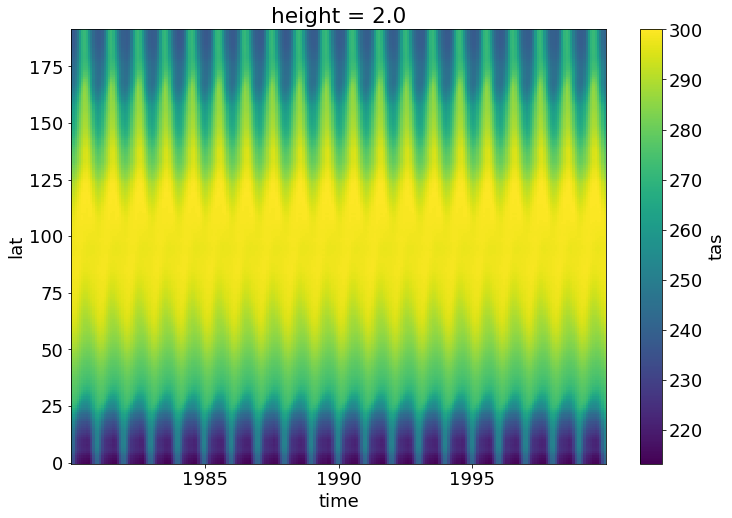

In [13]:
tmean.plot.pcolormesh('time', 'lat')